In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Embedding, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot

In [3]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])

In [4]:
def example_of_usage():
    future_num_predic_steps = 1
    past_steps_to_use = 4
    arr = np.array([1,2,3,4,5,6,7,8,9,10][:-future_num_predic_steps])
    arr2 = np.array([11, 12, 13, 14,15, 16,17,18,19, 20][:-future_num_predic_steps])
    Y = np.array([111,112, 113, 114,115, 116,117,118,119, 120])


    #Y = np.array([211,212, 213, 214,215, 216,217,218,219, 220])

    X = create_window_data_arrays((arr, arr2), past_steps_to_use)
    Y = create_window_data_array_with_shift(Y,future_num_predic_steps,past_steps_to_use +future_num_predic_steps)
    print(X)
    print(Y)
    print(X.shape)
    print(Y.shape)
example_of_usage()

[[[ 2 12]
  [ 3 13]
  [ 4 14]
  [ 5 15]]

 [[ 3 13]
  [ 4 14]
  [ 5 15]
  [ 6 16]]

 [[ 4 14]
  [ 5 15]
  [ 6 16]
  [ 7 17]]

 [[ 5 15]
  [ 6 16]
  [ 7 17]
  [ 8 18]]

 [[ 6 16]
  [ 7 17]
  [ 8 18]
  [ 9 19]]]
[[116]
 [117]
 [118]
 [119]
 [120]]
(5, 4, 2)
(5, 1)


In [5]:
directory = '../data/'
df_empresas = pd.read_csv(directory + "grouped_data_day_mean_tweets_sentimentdata-scraper_empresas_peru_2019-2020..csv", sep=";", encoding="ISO-8859-1")
df_empresas["normalised_date"]= pd.to_datetime(df_empresas["normalised_date"]) 
df_empresas = df_empresas.rename(columns={"sentiment": "sentiment_empresas"})

df = pd.read_csv(directory + "stocks_and_sentiment_2020.csv", sep=";", names=['date','sentiment','price'], encoding="ISO-8859-1")
df["date"]= pd.to_datetime(df["date"]) 
df = df.rename(columns={"sentiment": "sentiment_asoc"})

df = df_empresas.merge(df, left_on="normalised_date", right_on="date")
df = df[["sentiment_empresas", "sentiment_asoc", "price"]]
df.head()

,sentiment_empresas,sentiment_asoc,price
0,0.243997,0.219692,-0.169729
1,0.185506,0.214739,0.262752
2,0.130081,0.247731,0.298582
3,0.141136,0.232923,0.320586
4,0.156070,0.284574,0.642212


In [58]:
filename_asoc = "../data/grouped_data_day_mean_tweets_sentimentdata-scraper_asociaciones_peru-2016-2020.csv"
filename_empresas ="../data/grouped_data_day_mean_tweets_sentimentdata-scraper_empresas_peru_2018-2020.csv"
filename_precios_bolsa = "../data/pe_bvl_mean_day.csv"

df_asoc = pd.read_csv(filename_asoc, sep=";")
df_empresas = pd.read_csv(filename_empresas, sep=";")
df_precios_bolsa = pd.read_csv(filename_precios_bolsa, sep=";")

df_total = pd.merge(left=df_asoc, right=df_empresas, left_on='normalised_date', right_on='normalised_date')
df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_empresas"})
df_total["normalised_date"]= pd.to_datetime(df_total["normalised_date"]) 
df_total = df_total[["normalised_date","sentiment_asociacones", "sentiment_empresas"]]

df_precios_bolsa = df_precios_bolsa[["date", "price_change"]]
df_precios_bolsa["date"]= pd.to_datetime(df_precios_bolsa["date"]) 
df_total = pd.merge(left=df_total, right=df_precios_bolsa, left_on='normalised_date', right_on='date')

df_total.sentiment_asociacones = df_total.sentiment_asociacones.diff()
df_total.sentiment_empresas = df_total.sentiment_empresas.diff()
df_total = df_total.dropna()
df_total = df_total.rename(columns={"price_change": "peru_change"})
df_total['sentiment_asociacones'] = df_total['sentiment_asociacones'].astype(float)
df_total['sentiment_empresas'] = df_total['sentiment_empresas'].astype(float)
df_total['peru_change'] = df_total['peru_change'].astype(float)


df_total = df_total[:-100]
df_total

,normalised_date,sentiment_asociacones,sentiment_empresas,date,peru_change
1,2017-11-17,-0.009226,0.031482,2017-11-17,0.389762
2,2017-11-20,-0.102884,-0.030351,2017-11-20,1.125976
3,2017-11-21,0.092311,-0.029591,2017-11-21,0.507174
4,2017-11-22,-0.033172,0.084686,2017-11-22,0.248961
5,2017-11-23,-0.005907,-0.047634,2017-11-23,0.394683
...,...,...,...,...,...
531,2019-12-30,-0.034066,0.017559,2019-12-30,-0.178584
532,2019-12-31,0.299061,-0.018118,2019-12-31,0.864454
533,2020-01-02,-0.353609,-0.039454,2020-01-02,-0.772431
534,2020-01-03,0.015198,0.023522,2020-01-03,-0.406118


In [65]:


from sklearn.preprocessing import MinMaxScaler

#X = scaler.fit_transform(df_diff.values)
#X_sent_asoc = X[:,0][:-future_steps]
#X_prices = X[:,1][:-future_steps]
#X_prices_next = X[:,1]


#plt.plot(X)

num_steps = 7
future_steps = 1

X_sent_asoc = df_total.sentiment_asociacones.values[:-future_steps]
X_sent_empresas = df_total.sentiment_empresas.values[:-future_steps]
X_prices = df_total.peru_change.values[:-future_steps]
X_prices_next = df_total.peru_change.values

'''
scaler = MinMaxScaler(feature_range=(1, 2))
scaler = scaler.fit(df_total[["peru_change", "sentiment_empresas","sentiment_asociacones"]].values.reshape(-1,1))

shape = X_sent_asoc.shape
X_sent_asoc = X_sent_asoc.reshape(-1,1)
X_sent_asoc = scaler.transform(X_sent_asoc)
X_sent_asoc = X_sent_asoc.reshape(shape)

X_sent_empresas = X_sent_empresas.reshape(-1,1)
X_sent_empresas = scaler.transform(X_sent_empresas)
X_sent_empresas = X_sent_empresas.reshape(shape)

X_prices = X_prices.reshape(-1,1)
X_prices = scaler.transform(X_prices)
X_prices = X_prices.reshape(shape)

shape = X_prices_next.shape
X_prices_next = X_prices_next.reshape(-1,1)
X_prices_next = scaler.transform(X_prices_next)
X_prices_next = X_prices_next.reshape(shape)
'''

X = np.array(create_window_data_arrays((X_sent_asoc,X_sent_empresas, X_prices), num_steps))
Y = create_window_data_array_with_shift(X_prices_next, future_steps, num_steps +future_steps)
print(X.shape, Y.shape)

(527, 7, 3) (527, 1)


In [66]:

train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.20, shuffle=False)

'''
train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.10, random_state=1000)
'''


print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_y[-10:])

(421, 7, 3) (421, 1) (106, 7, 3) (106, 1)
[[-0.4330791 ]
 [-0.43699487]
 [ 0.11007716]
 [ 0.11298114]
 [-0.6478687 ]
 [-2.12890289]
 [-1.74335601]
 [-0.6151686 ]
 [-1.92549654]
 [-2.55126867]]


Train on 421 samples, validate on 106 samples
Epoch 1/100
 - 0s - loss: 0.5862 - accuracy: 0.0000e+00 - val_loss: 0.5693 - val_accuracy: 0.0000e+00
Epoch 2/100
 - 0s - loss: 0.5865 - accuracy: 0.0000e+00 - val_loss: 0.5698 - val_accuracy: 0.0000e+00
Epoch 3/100
 - 0s - loss: 0.5864 - accuracy: 0.0000e+00 - val_loss: 0.5696 - val_accuracy: 0.0000e+00
Epoch 4/100
 - 0s - loss: 0.5812 - accuracy: 0.0000e+00 - val_loss: 0.5695 - val_accuracy: 0.0000e+00
Epoch 5/100
 - 0s - loss: 0.5820 - accuracy: 0.0000e+00 - val_loss: 0.5698 - val_accuracy: 0.0000e+00
Epoch 6/100
 - 0s - loss: 0.5820 - accuracy: 0.0000e+00 - val_loss: 0.5705 - val_accuracy: 0.0000e+00
Epoch 7/100
 - 0s - loss: 0.5828 - accuracy: 0.0000e+00 - val_loss: 0.5711 - val_accuracy: 0.0000e+00
Epoch 8/100
 - 0s - loss: 0.5811 - accuracy: 0.0000e+00 - val_loss: 0.5719 - val_accuracy: 0.0000e+00
Epoch 9/100
 - 0s - loss: 0.5788 - accuracy: 0.0000e+00 - val_loss: 0.5717 - val_accuracy: 0.0000e+00
Epoch 10/100
 - 0s - loss: 0.5793 - 

Epoch 81/100
 - 0s - loss: 0.5718 - accuracy: 0.0000e+00 - val_loss: 0.5813 - val_accuracy: 0.0000e+00
Epoch 82/100
 - 0s - loss: 0.5659 - accuracy: 0.0000e+00 - val_loss: 0.5811 - val_accuracy: 0.0000e+00
Epoch 83/100
 - 0s - loss: 0.5750 - accuracy: 0.0000e+00 - val_loss: 0.5809 - val_accuracy: 0.0000e+00
Epoch 84/100
 - 0s - loss: 0.5735 - accuracy: 0.0000e+00 - val_loss: 0.5807 - val_accuracy: 0.0000e+00
Epoch 85/100
 - 0s - loss: 0.5706 - accuracy: 0.0000e+00 - val_loss: 0.5805 - val_accuracy: 0.0000e+00
Epoch 86/100
 - 0s - loss: 0.5682 - accuracy: 0.0000e+00 - val_loss: 0.5799 - val_accuracy: 0.0000e+00
Epoch 87/100
 - 0s - loss: 0.5698 - accuracy: 0.0000e+00 - val_loss: 0.5794 - val_accuracy: 0.0000e+00
Epoch 88/100
 - 0s - loss: 0.5684 - accuracy: 0.0000e+00 - val_loss: 0.5806 - val_accuracy: 0.0000e+00
Epoch 89/100
 - 0s - loss: 0.5749 - accuracy: 0.0000e+00 - val_loss: 0.5812 - val_accuracy: 0.0000e+00
Epoch 90/100
 - 0s - loss: 0.5684 - accuracy: 0.0000e+00 - val_loss: 0.58

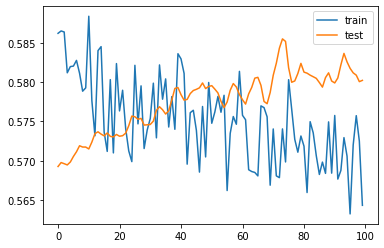

In [71]:
output_size = future_steps
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.6))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(output_size))

model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 421 samples, validate on 106 samples
Epoch 1/100
 - 0s - loss: 0.6509 - accuracy: 0.0000e+00 - mae: 0.6509 - val_loss: 0.5674 - val_accuracy: 0.0000e+00 - val_mae: 0.5674
Epoch 2/100
 - 0s - loss: 0.6079 - accuracy: 0.0000e+00 - mae: 0.6079 - val_loss: 0.5660 - val_accuracy: 0.0000e+00 - val_mae: 0.5660
Epoch 3/100
 - 0s - loss: 0.5951 - accuracy: 0.0000e+00 - mae: 0.5951 - val_loss: 0.5661 - val_accuracy: 0.0000e+00 - val_mae: 0.5661
Epoch 4/100
 - 0s - loss: 0.5943 - accuracy: 0.0000e+00 - mae: 0.5943 - val_loss: 0.5674 - val_accuracy: 0.0000e+00 - val_mae: 0.5674
Epoch 5/100
 - 0s - loss: 0.5927 - accuracy: 0.0000e+00 - mae: 0.5927 - val_loss: 0.5677 - val_accuracy: 0.0000e+00 - val_mae: 0.5677
Epoch 6/100
 - 0s - loss: 0.5803 - accuracy: 0.0000e+00 - mae: 0.5803 - val_loss: 0.5666 - val_accuracy: 0.0000e+00 - val_mae: 0.5666
Epoch 7/100
 - 0s - loss: 0.5864 - accuracy: 0.0000e+00 - mae: 0.5864 - val_loss: 0.5672 - val_accuracy: 0.0000e+00 - val_mae: 0.5672
Epoch 8/100
 - 0

Epoch 62/100
 - 0s - loss: 0.5757 - accuracy: 0.0000e+00 - mae: 0.5757 - val_loss: 0.5668 - val_accuracy: 0.0000e+00 - val_mae: 0.5668
Epoch 63/100
 - 0s - loss: 0.5764 - accuracy: 0.0000e+00 - mae: 0.5764 - val_loss: 0.5669 - val_accuracy: 0.0000e+00 - val_mae: 0.5669
Epoch 64/100
 - 0s - loss: 0.5789 - accuracy: 0.0000e+00 - mae: 0.5789 - val_loss: 0.5667 - val_accuracy: 0.0000e+00 - val_mae: 0.5667
Epoch 65/100
 - 0s - loss: 0.5766 - accuracy: 0.0000e+00 - mae: 0.5766 - val_loss: 0.5662 - val_accuracy: 0.0000e+00 - val_mae: 0.5662
Epoch 66/100
 - 0s - loss: 0.5800 - accuracy: 0.0000e+00 - mae: 0.5800 - val_loss: 0.5658 - val_accuracy: 0.0000e+00 - val_mae: 0.5658
Epoch 67/100
 - 0s - loss: 0.5754 - accuracy: 0.0000e+00 - mae: 0.5754 - val_loss: 0.5668 - val_accuracy: 0.0000e+00 - val_mae: 0.5668
Epoch 68/100
 - 0s - loss: 0.5820 - accuracy: 0.0000e+00 - mae: 0.5820 - val_loss: 0.5673 - val_accuracy: 0.0000e+00 - val_mae: 0.5673
Epoch 69/100
 - 0s - loss: 0.5693 - accuracy: 0.0000e+0

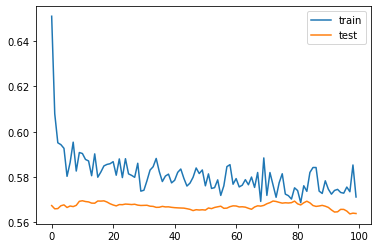

In [69]:
output_size = future_steps
n_timesteps = train_X.shape[1]
n_features = train_X.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(output_size))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=40, validation_data=(test_X, test_y), verbose=2,  callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

106/106 [==============================] - 0s 541us/step
0.5802258089138372
[[-4.12517324e-01 -8.49263787e-01]
 [ 1.56352833e+00 -5.89552164e-01]
 [ 2.49427431e-01  1.55312359e-01]
 [-8.10900006e-01  7.81837851e-02]
 [-1.91891261e+00  3.53558138e-02]
 [ 6.77757190e-01 -4.48779464e-02]
 [-1.85325265e+00  9.24816728e-02]
 [-5.35253769e-01  2.46433765e-02]
 [ 5.37963337e-01  3.41998786e-02]
 [ 1.16754379e+00 -4.08764649e-03]
 [-1.23562974e-01  8.63422975e-02]
 [-4.94658007e-01  4.44708914e-02]
 [-7.56921710e-01  2.31068134e-02]
 [-1.09764741e-01  3.50744743e-03]
 [-4.59929070e-01  2.60008499e-04]
 [ 5.36988766e-01 -3.36950808e-03]
 [ 6.37016150e-01  2.27339454e-02]
 [ 2.88367256e-01  2.27800421e-02]
 [ 9.77598953e-01  1.07907234e-02]
 [-3.66139812e-01  7.20397159e-02]
 [ 4.11070347e-01  4.74721789e-02]
 [ 2.06217536e+00  5.69301993e-02]
 [-1.11938983e-01  2.18854994e-01]
 [-8.76069202e-01  1.34505957e-01]
 [ 1.24718912e-01  1.00986525e-01]
 [ 5.68919827e-01  1.16564475e-01]
 [ 7.16853641e

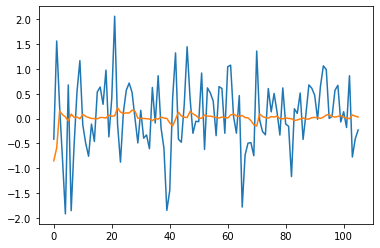

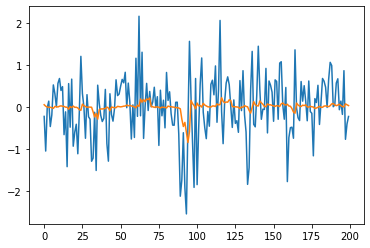

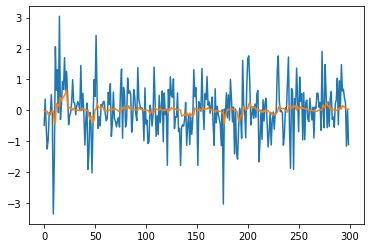

In [72]:

#https://datascience.stackexchange.com/a/45172
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred))

M = np.column_stack((test_y, y_pred))
#M_untransformed = scaler.inverse_transform(M)

#y_pred_un = scaler.inverse_transform(y_pred.reshape((len(y_pred),1)))
#test_y_un = scaler.inverse_transform(test_y.reshape((len(test_y),1)))

print(M)


plot1 = plt.figure(1)
plt.plot(M)



print("---")
#print(M_untransformed)

#print(df_total.values[-3:])


def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = model.predict(X, batch_size=40, verbose=1)
print(mean_absolute_error(Y, y_pred))
print(r2_score(y_pred,Y))
print(mean_absolute_percentage_error(y_pred,Y))



M = np.column_stack((Y, y_pred))
plot1 = plt.figure(2)
plt.plot(M[-200:])

y_pred_train = model.predict(train_X, batch_size=40, verbose=1)
print(mean_absolute_error(train_y, y_pred_train))
print(r2_score(y_pred_train,train_y))

M = np.column_stack((train_y, y_pred_train))

plot1 = plt.figure(3)
plt.plot(M[:300])

plt.show()

In [ ]:
Y_null_model = Y